In [1]:
%%capture
from lmi import lmi
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

import time
import os

from sklearn.metrics import roc_auc_score, roc_curve

torch.manual_seed(2121)

In [2]:
pxf = pd.read_csv('../data/ProtT5_embeddings/OP_kinases.csv', index_col=0)
kinases = [x for x in pxf.keys() if x[:7] == 'Kinase_']
targets = [x for x in pxf.keys() if x[:7] == 'Target_']

prots = list(set(list(pxf['Kinase UniProt'].values) + list(pxf['Target UniProt'].values)))
print('Total proteins: %d' %(len(prots)))

Total proteins: 5150


In [3]:
trials = range(20)

d = {
    'Trial number' : [],
    'TPR' : [],
    'FPR' : [],
    'ROCAUC' : []
}

for T in tqdm(trials):
    
    held_out = np.random.choice(prots, 170)

    train = pxf[(~pxf['Kinase UniProt'].isin(held_out)) & (~pxf['Target UniProt'].isin(held_out))]
    val = pxf[(pxf['Kinase UniProt'].isin(held_out)) | (pxf['Target UniProt'].isin(held_out))]
    assert len(train) + len(val) == len(pxf), "Something wrong with split"

    # cursed
    train_inds = [pxf.index.get_loc(train.iloc[i].name) for i in range(len(train))]
    val_inds = [pxf.index.get_loc(val.iloc[i].name) for i in range(len(val))]

    held_out_embeddings = {}
    for h in held_out:

        h_is_k = pxf[pxf['Kinase UniProt'] == h]
        if len(h_is_k) > 0:
            held_out_embeddings[h] = h_is_k.iloc[0][kinases].values
        else:
            h_is_t = pxf[pxf['Target UniProt'] == h]
            held_out_embeddings[h] = h_is_t.iloc[0][targets].values

    pairs = list(zip(np.repeat(held_out, len(held_out), axis=0),
                       np.tile(held_out, (len(held_out), 1)).flatten()))
    
    kts = [tuple(x) for x in pxf[['Kinase UniProt', 'Target UniProt']].values]

    annotations = [p in kts for p in pairs]

    # print("Training set size: %d" %len(train_inds))

    Xs = pxf[kinases].to_numpy()
    Ys = pxf[targets].to_numpy()

    Xs = np.nan_to_num((Xs - Xs.mean(axis=0)) / Xs.std(axis=0))
    Ys = np.nan_to_num((Ys - Ys.mean(axis=0)) / Ys.std(axis=0))

    pxf[kinases], pxf[targets] = Xs, Ys

    Xs, Ys = torch.from_numpy(Xs).float().cuda(), torch.from_numpy(Ys).float().cuda()

    Xs = torch.clip(Xs, min=-10, max=10)
    Ys = torch.clip(Ys, min=-10, max=10)

    Zx, Zy, model = lmi.ae(Xs, Ys, train_inds, val_inds, quiet=True)



    qXs = [held_out_embeddings[h].astype(float) for h in held_out]
    qYs = [held_out_embeddings[h].astype(float) for h in held_out]

    qXs = torch.from_numpy(np.repeat(qXs, len(qXs), axis=0))
    qYs = torch.from_numpy(np.tile(qYs, (len(qYs), 1)))

    qXs = torch.from_numpy(np.nan_to_num((qXs - qXs.mean(axis=0)) 
                                         / qXs.std(axis=0))).float().cuda()
    qYs = torch.from_numpy(np.nan_to_num((qYs - qYs.mean(axis=0)) 
                                         / qYs.std(axis=0))).float().cuda()

    with torch.no_grad():
        qZx, qZy = model.encode(qXs, qYs)
        qZx, qZy = qZx.cpu(), qZy.cpu()

    pred = lmi.ksg.out_of_sample_pmi(Zx, 
                               Zy, 
                               qZx, 
                               qZy)

    fpr, tpr, th = roc_curve(annotations, pred, drop_intermediate=False)
    roc_auc = roc_auc_score(annotations, pred)
    
    d['Trial number'] += [T]*len(fpr)
    d['FPR'] += list(fpr)
    d['TPR'] += list(tpr)
    d['ROCAUC'] += [roc_auc]*len(fpr)

  0%|          | 0/20 [00:00<?, ?it/s]

In [4]:
df = pd.DataFrame(d)

(0.0, 1.0)

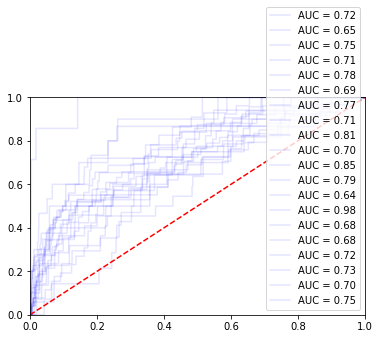

In [5]:
for T in trials:
    fpr = df[df['Trial number'] == T]['FPR']
    tpr = df[df['Trial number'] == T]['TPR']
    roc_auc = df[df['Trial number'] == T]['ROCAUC'].iloc[0]
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc, alpha=0.1)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])

In [6]:
df.to_csv('../results/OP_kinases_roc.csv')